## Homework 3: Due 2017-11-03

Write a solver for the regularized $p$-Laplacian,
$$ -\nabla\cdot\big( \kappa(\nabla u) \nabla u \big) = 0 $$
where
$$ \kappa(\nabla u) = \big(\frac 1 2 \epsilon^2 + \frac 1 2 \nabla u \cdot \nabla u \big)^{\frac{p-2}{2}}, $$
$ \epsilon > 0$, and $1 < p < \infty$.  The case $p=2$ is the conventional Laplacian. This problem gets more strongly nonlinear when $p$ is far from 2 and when $\epsilon$ approaches zero. The $p \to 1$ limit is related to plasticity and has applications in non-Newtonion flows and structural mechanics.

1. Implement a "Picard" solver, which is like a Newton solver except that the Jacobian is replaced by the linear system
$$ J_{\text{Picard}}(u) \delta u \sim -\nabla\cdot\big( \kappa(\nabla u) \nabla \delta u \big) . $$
This is much easier to implement than the full Newton linearization.

***
First, I will make use of:

$$ \nabla u \cdot \nabla u  =  \lVert{ \nabla u} \rVert^2 $$



 0: anorm 1.000000e+00
 1: anorm 2.062692e-01
 2: anorm 3.116085e-02
 3: anorm 3.451438e-03
 4: anorm 3.027651e-04
 5: anorm 2.199427e-05
 6: anorm 1.360815e-06
 7: anorm 7.319307e-08
 8: anorm 3.470148e-09


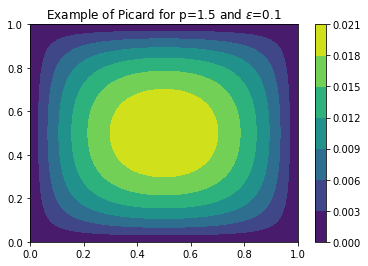

In [5]:
import numpy
from matplotlib import pyplot
import scipy.sparse as sp
import scipy.sparse.linalg
import profile
import pstats

def hgrid(h):
    m = int(1/h + 1)  # Number of elements in terms of nominal grid spacing h
    h = 1 / (m-1)     # Actual grid spacing
    c = numpy.linspace(0, 1, m)
    y, x = numpy.meshgrid(c, c)
    return x, y

def nonlinear2d_Picard(h, x, y, u,p, epsilon, forcing, g0, dirichlet=((),())):
    m = x.shape[0]
    u0 = g0(x, y).flatten()
    F = -forcing(x, y).flatten()
    ai = []
    aj = []
    av = []
    def idx(i, j):
        i = (m-1) - abs(m-1 - abs(i))
        j = (m-1) - abs(m-1 - abs(j))
        return i*m + j
    mask = numpy.ones_like(x, dtype=bool)
    mask[dirichlet[0],:] = False
    mask[:,dirichlet[1]] = False
    mask = mask.flatten()
    u = u.flatten()
    F[mask == False] = u[mask == False] - u0[mask == False]
    u[mask == False] = u0[mask == False]
    for i in range(m):
        for j in range(m):
            row = idx(i, j)
            stencili = numpy.array([idx(*pair) for pair in [(i-1, j), (i, j-1), (i, j), (i, j+1), (i+1, j)]])
            
            # Stencil to evaluate gradient at four staggered points
            grad = numpy.array([[-1, 0, 1, 0, 0],
                                [0, -1, 1, 0, 0],
                                [0, 0, -1, 1, 0],
                                [0, 0, -1, 0, 1]]) / h
            # Stencil to average at four staggered points
            #avg  = numpy.array([[1, 0, 1, 0, 0],
            #                    [0, 1, 1, 0, 0],
            #                    [0, 0, 1, 1, 0],
            #                    [0, 0, 1, 0, 1]]) / 2
            # Stencil to compute divergence at cell centers from fluxes at four staggered points
            div = numpy.array([-1, -1, 1, 1]) / h
            ustencil = u[stencili]
            #ustag = avg @ ustencil
            kappa = ((1./2.)*epsilon**2 + (1./2.)*(numpy.linalg.norm(grad@ustencil))**2)**((p-2.)/2.)
            if mask[row] == 0: # Dirichlet boundary
                ai.append(row)
                aj.append(row)
                av.append(1)
            else:
                F[row] -= div @ (kappa * grad @ ustencil)
                #JPicard:
                Jstencil = -div @ (kappa* grad)
                   # + 2*(ustag*(grad @ ustencil))[:,None] * avg)
                smask = mask[stencili]
                ai += [row]*sum(smask)
                aj += stencili[smask].tolist()
                av += Jstencil[smask].tolist()
    J = sp.csr_matrix((av, (ai, aj)), shape=(m*m,m*m))
    return F, J

def solve_nonlinear(h, g0, p, epsilon, dirichlet, atol=1e-8, verbose=False):
    x, y = hgrid(h)
    u = 0*x
    for i in range(50):
        F, J = nonlinear2d_Picard(h, x, y, u,p,epsilon, lambda x,y: 0*x+1,
                               lambda x,y: 0*x, dirichlet=((0,-1),(0,-1)))
        anorm = numpy.linalg.norm(F, numpy.inf)
        if verbose:
            print('{:2d}: anorm {:8e}'.format(i,anorm))
        if anorm < atol:
            break
        deltau = sp.linalg.spsolve(J, -F)
        u += deltau.reshape(x.shape)
    return x, y, u, i
                                                               
epsilon= 0.1
p1=[1.5]

for index,p in enumerate(p1):
    x, y, u, i = solve_nonlinear(.01, lambda x,y: 0*x, p, epsilon, dirichlet=((0,-1),(0,-1)), verbose=True)
    pyplot.contourf(x, y, u)
    pyplot.colorbar();
    pyplot.title('Example of Picard for p='+ repr(p) + ' and $\epsilon$=' + repr(epsilon))
    pyplot.show()

**How fast does this method converge for values of $p < 2$ and $p > 2$?**

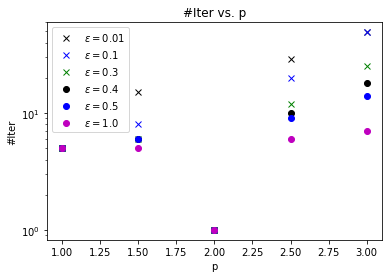

In [8]:
p1=[1,1.5,2,2.5, 3]
eps=[0.01, 0.1, 0.3, 0.4, 0.5, 1.]

colors = ['xk','xb','xg','ok', 'ob', 'om']

for in1, epsilon in enumerate(eps):
    pees = []
    eyes = []
    for index,p in enumerate(p1):
        x, y, u, i = solve_nonlinear(.1, lambda x,y: 0*x, p, epsilon, dirichlet=((0,-1),(0,-1)), verbose=False)
        pyplot.title('#Iter vs. p')
        pees.append(p)
        eyes.append(i)
    pyplot.semilogy(pees,eyes, colors[in1], label='$ \epsilon= {0}$'.format(epsilon))
    pyplot.xlabel('p')
    pyplot.ylabel('#Iter')
    pyplot.legend(loc='upper left');  
pyplot.show()
  

There is not much information I can get from this plot unless I normalize the y-axis by a scale. This is why I did the following. 

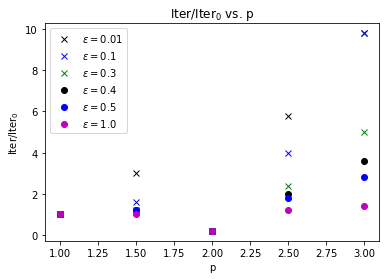

In [10]:
p1=[1,1.5,2,2.5, 3]
eps=[0.01, 0.1, 0.3, 0.4, 0.5, 1.]

colors = ['xk','xb','xg','ok', 'ob', 'om']

for in1, epsilon in enumerate(eps):
    pees = []
    eyes = []
    for index,p in enumerate(p1):
        x, y, u, i = solve_nonlinear(.1, lambda x,y: 0*x, p, epsilon, dirichlet=((0,-1),(0,-1)), verbose=False)
        pyplot.title('Iter/Iter$_{0}$ vs. p')
        pees.append(p)
        if index==0:
            eye= i
        eyes.append(i/eye)
    pyplot.plot(pees,eyes, colors[in1], label='$ \epsilon= {0}$'.format(epsilon))
    pyplot.legend(loc='upper left');  
    pyplot.xlabel('p')
    pyplot.ylabel('Iter/Iter$_{0}$')
pyplot.show()

**My observations**: My measurement for how "fast" the method runs for different p's is the number of iterations. I took the ratios of the number of iterations that it takes for the method to converge compared to how many iterations it takes for the method to converge at $p=1$. My take-away from this plot is that for most $\epsilon$'s, the increase in iterations as p increases. However, for $p<2$, this increase will not be too dramatic. Strangely, for $p=2$, it takes less iterations than at $p=1$ for all values of $\epsilon$. This might be because we are dealing with the conventional Laplacian. 

For $p>2$, however, as $\epsilon$ increases, the number of iterations needed to solve the problem compared to $p=1$ decreases. For very small $\epsilon$, we can get the case where convergence is compromised too for large values of p. 

## Question 2: Newton-Krylov

* Use the linearization above as a preconditioner to a Newton-Krylov method.  That is, use [`scipy.sparse.linalg.LinearOperator`](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.sparse.linalg.LinearOperator.html) to apply the Jacobian to a vector
$$ \tilde J(u) v = \frac{F(u + h v) - F(u)}{h} . $$
Then for each linear solve, use [`scipy.sparse.linalg.gmres`](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.sparse.linalg.gmres.html) and pass as a preconditioner, a direct solve with the Picard linearization above. (You might find [`scipy.sparse.linalg.factorized`](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.sparse.linalg.factorized.html#scipy.sparse.linalg.factorized) to be useful. Compare algebraic convergence to that of the Picard method.

***
I made use of the examples in the link below:
https://www.programcreek.com/python/example/57163/scipy.sparse.linalg.LinearOperator

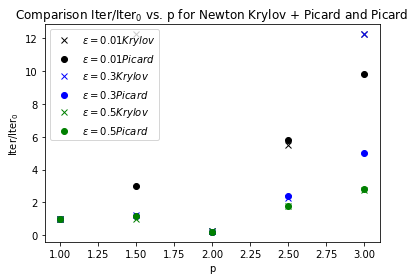

In [200]:
def solve_nonlinearNK(h, g0, p, epsilon, dirichlet, atol=1e-6, verbose=False):
    x, y = hgrid(h)
    u = 0*x
    for i in range(50):
        F, J = nonlinear2d_Picard(h, x, y, u,p,epsilon, lambda x,y: 0*x+1,
                               lambda x,y: 0*x, dirichlet=((0,-1),(0,-1)))
        anorm = numpy.linalg.norm(F, numpy.inf)
        if verbose:
            print('{:2d}: anorm {:8e}'.format(i,anorm))
        if anorm < atol:
            break
            
        # I tried to do LU decomposition, but for some reason it gave me an ill-conditioned matrix. I would be happy
        # to talk about this phenomenon next week. 
        Ax = lambda x: scipy.sparse.linalg.spsolve(J, x)
        A= scipy.sparse.linalg.LinearOperator(J.shape, Ax)
        
        # Using GMRES:
        deltau, info = scipy.sparse.linalg.gmres(J, -F, x0=None, tol=1e-05, restart=None, maxiter=100, xtype=None,
                                                 M=A, callback=None, restrt=None)

        u += deltau.reshape(x.shape)
    return x, y, u, i
                                                              
p1= [1, 1.5, 2, 2.5, 3]
eps=[0.01, 0.3, 0.5]

colors = ['xk','xb','xg']
colors1 = ['ok','ob','og']
for in1, epsilon in enumerate(eps):
    pees = []
    eyes = []
    pees1= []
    eyes1= []
    for index,p in enumerate(p1):

        x, y, u, i = solve_nonlinearNK(.1, lambda x,y: 0*x, p, epsilon, dirichlet=((0,-1),(0,-1)), verbose=False)
        x1, y1, u1, i1 = solve_nonlinear(.1, lambda x,y: 0*x, p, epsilon, dirichlet=((0,-1),(0,-1)), verbose=False)
        pyplot.title('Comparison Iter/Iter$_{0}$ vs. p for Newton Krylov + Picard and Picard')
        pees.append(p)
        pees1.append(p)
        if index==0:
            eye= i
            eye1= i1
        eyes.append(i/eye)
        eyes1.append(i1/eye1)
    pyplot.plot(pees,eyes, colors[in1], label='$ \epsilon= {0} Krylov$'.format(epsilon))
    pyplot.plot(pees1,eyes1,colors1[in1], label='$ \epsilon= {0} Picard$'.format(epsilon))
    pyplot.legend(loc='upper left');  
    pyplot.xlabel('p')
    pyplot.ylabel('Iter/Iter$_{0}$')
pyplot.show()

**My observations**: The increase of computing time compared to the $p=1$ case is either the same or slighly higher for the Picard solver at $p<2$. However, for $p>2$, the Picard solver converges and it becomes very difficult for the Krylov (at least my implementation) method to converge. As $\epsilon$ tends to 0, the solving time for Krylov becomes closer to Picard. 

** Can you directly implement a Newton linearization?  Either do it or explain what is involved.  How will its nonlinear convergence compare to that of the Newton-Krylov method?**

I did not have enough time to implement the Newton linearization. However, I believe it would require to perform the derivative of the left hand side and it would also require that the ratio between that derivative and the function evaluated at all points does not result in a division by zero. As mentioned previously in class, the Newton-Raphsen method would require far more iterations than Krylov or only Picard. 